# Finloop PV segmentation with SAM

source (Huggingface): finloop/yolov8s-seg-solar-panels (aka Rzeszów model)

credits: https://blog.roboflow.com/how-to-use-yolov8-with-sam/ (Roboflow)

VI 25 with changes 15 X 25, 9 XI 25 and on

*MD*

note: a dual-use model (detection + instance segmentation)

requires OBB-versioned datasets

here: detect-YOLO

## libs

In [21]:
# %pip install numpy
# %pip install pandas
# %pip install ultralytics

In [22]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO, SAM
import torch

In [23]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda', index=0)

## defs

### data

In [24]:
pilot = 'pilotPV_panels.v1i.yolov8-obb/test/images/*.jpg'
rzeszow_test = 'rzeszowSolar panels seg.v2i.yolov8-obb/test/images/*.jpg'
rzeszow_train = 'rzeszowSolar panels seg.v2i.yolov8-obb/train/images/*.jpg'
rzeszow_valid = 'rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/*.jpg'
synth_test = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/*.jpg'
synth_train = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/*.jpg'
synth_valid = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/*.jpg'

In [25]:
proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg"
data_p = proste_1_zdj
pth = proste_1_zdj
nazwa = "proste_1_zdj"

### model

In [26]:
model_pt = "best.pt"

In [27]:
model = YOLO(model=model_pt, task="detect", verbose=True)

In [28]:
sam = SAM("sam_b.pt")

### segment analysis

In [29]:
def sum_pv_segments(pth, nazwa="no_info_run", model=model, print_info=False, disp_img=False, display_coef=100):
    pv_area = 0
    yolo_results = model(pth, save=print_info, name=nazwa, stream=True, device=dev, verbose=print_info)
    for i, res in enumerate(yolo_results):
        dsp = disp_img and i % display_coef == 0
        ppth = res.path
        if dsp:
            image = cv2.cvtColor(cv2.imread(ppth), cv2.COLOR_BGR2RGB)
            image = torch.tensor(image, device=dev)
            img_w, img_h, _ = image.shape
        if res is not None and res.boxes is not None and res.boxes.xyxy is not None and len(res.boxes.xyxy > 0): # null-len res.boxes.xyxy for no PV
            sam_results = sam.predict(source=ppth, bboxes=res.boxes.xyxy)
            if sam_results is not None and sam_results[0] is not None and sam_results[0].masks is not None and sam_results[0].masks.data is not None:
                binary_mask = torch.where(sam_results[0].masks.data == True, 1, 0)
                pv_area += binary_mask.sum().div(640*640) # percentage
                if dsp:
                    for j, mask in enumerate(binary_mask):
                        mask = mask.data
                        bcg_white = torch.ones_like(image)*255
                        new_image = bcg_white * (1 - mask[..., torch.newaxis]) + image * mask[..., torch.newaxis]
                        plt.imshow(new_image.reshape((img_w, img_h, 3)).cpu())
                        plt.title(f"Mask {j} in {ppth[ppth.rfind('/'):]}")
                        plt.axis('off')
                        plt.show()
                if print_info:
                    print(i, pv_area.item())
        if dsp:
            plt.imshow(image.cpu())
            plt.title(f"base img {ppth[ppth.rfind('/'):]}")
            plt.axis('off')
            plt.show()
    return pv_area

## segment

### numbers

jeden obraz

In [30]:
sumka = sum_pv_segments(data_p, "proste_funk")
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1131.8ms
Speed: 7.2ms preprocess, 1131.8ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.0966, device='cuda:0')

In [31]:
sumka = sum_pv_segments(data_p, "proste_funk", print_info=True)
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 30.5ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1125.9ms
Speed: 6.3ms preprocess, 1125.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)
0 0.09656249731779099
Speed: 7.2ms preprocess, 30.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/proste_funk53


tensor(0.0966, device='cuda:0')

podwójnie

In [32]:
sum_pv_segments([data_p,data_p], "proste_funk_podwojnie")


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1131.7ms
Speed: 15.5ms preprocess, 1131.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1128.3ms
Speed: 10.0ms preprocess, 1128.3ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.1931, device='cuda:0')

### imgs


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1131.7ms
Speed: 16.9ms preprocess, 1131.7ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)


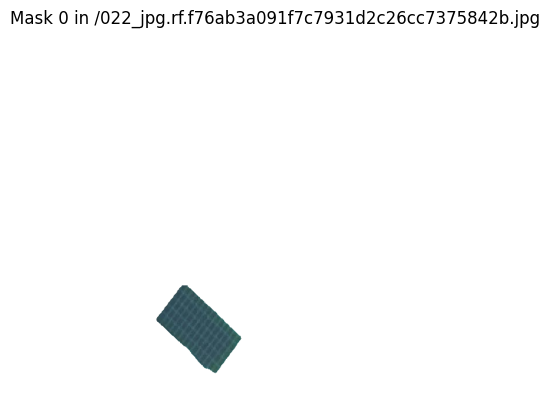

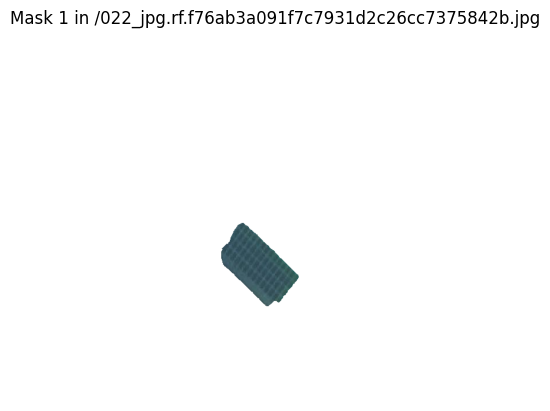

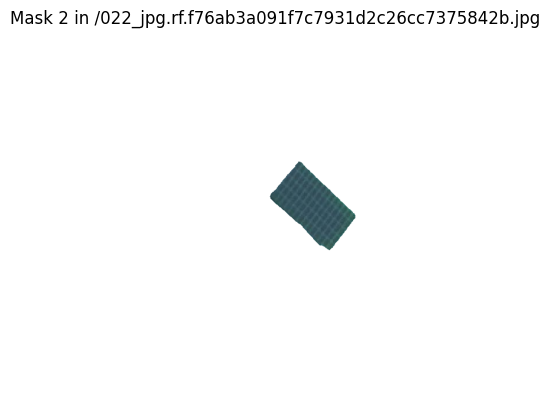

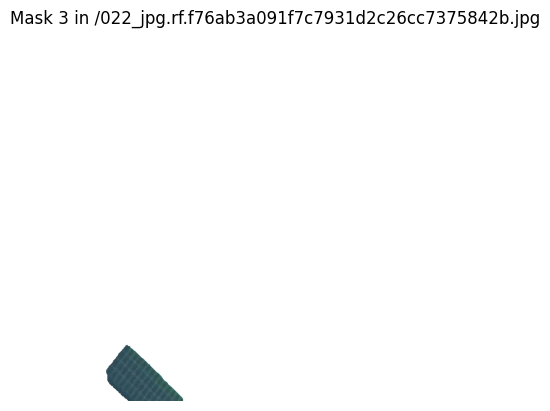

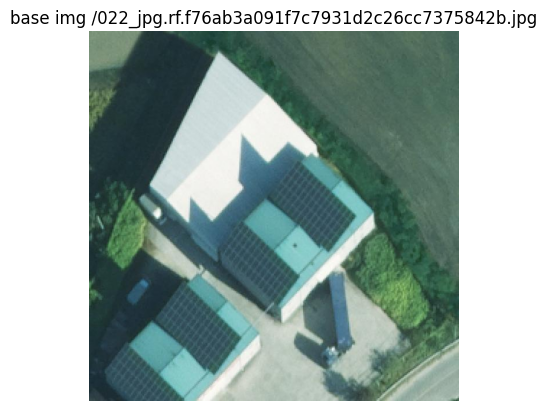

tensor(0.0966, device='cuda:0')

In [33]:
sum_pv_segments(data_p, "proste_funk", disp_img=True)


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1124.8ms
Speed: 29.2ms preprocess, 1124.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


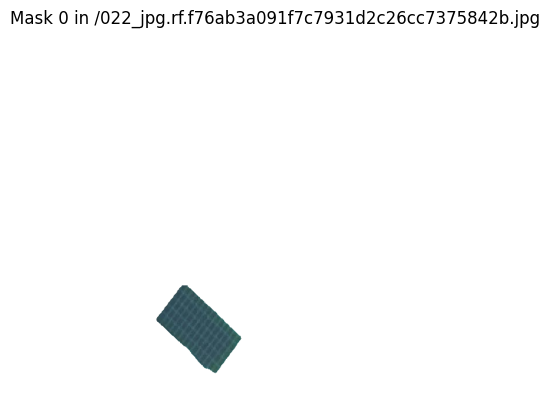

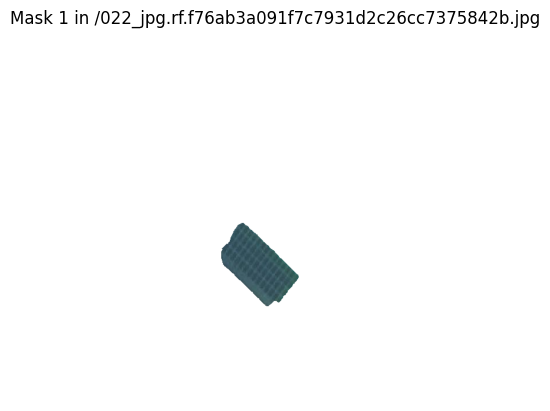

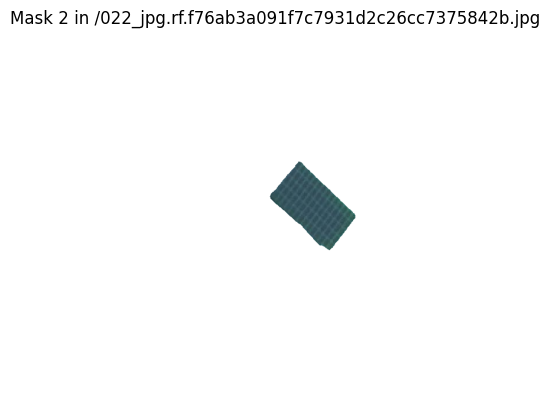

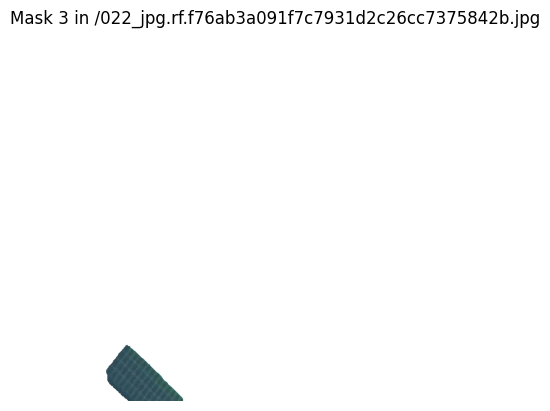

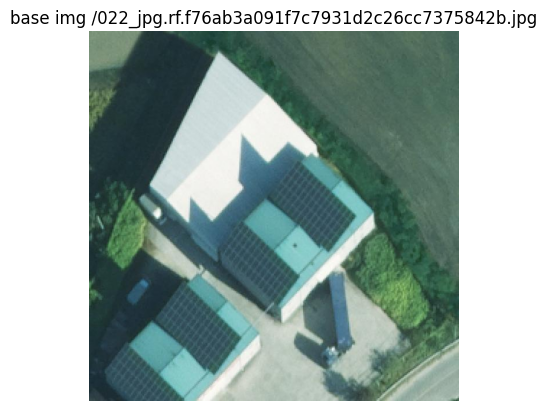


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1099.1ms
Speed: 6.2ms preprocess, 1099.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.1931, device='cuda:0')

In [34]:
sum_pv_segments([data_p,data_p], "proste_funk_podwojnie", disp_img=True)

## pilot


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-291-_png.rf.c105b47207c9dc4203900bab38f73c89.jpg: 1024x1024 1 0, 1 1, 1 2, 1113.2ms
Speed: 6.2ms preprocess, 1113.2ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)


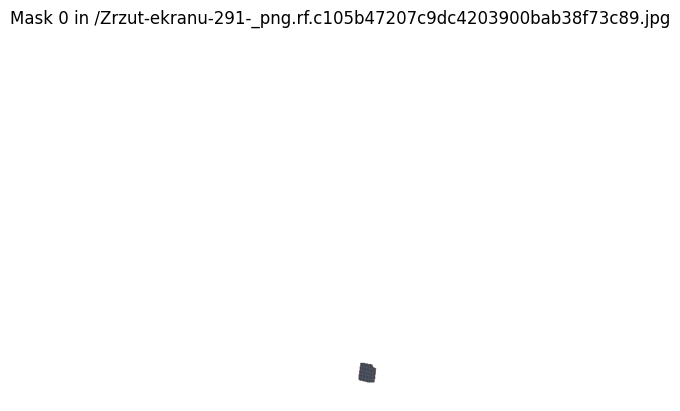

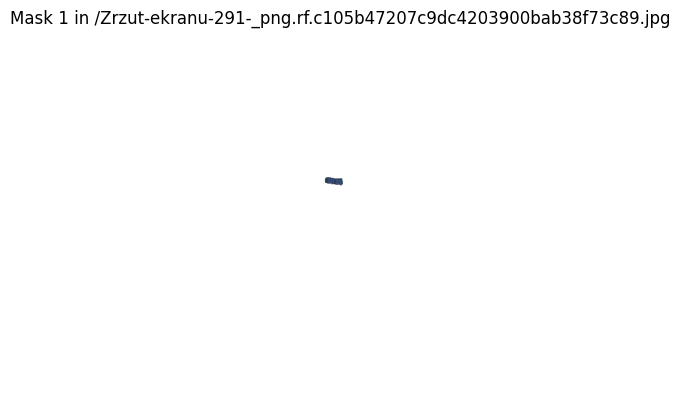

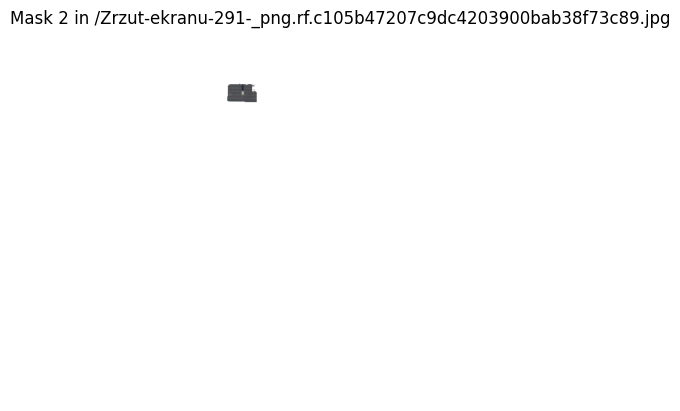

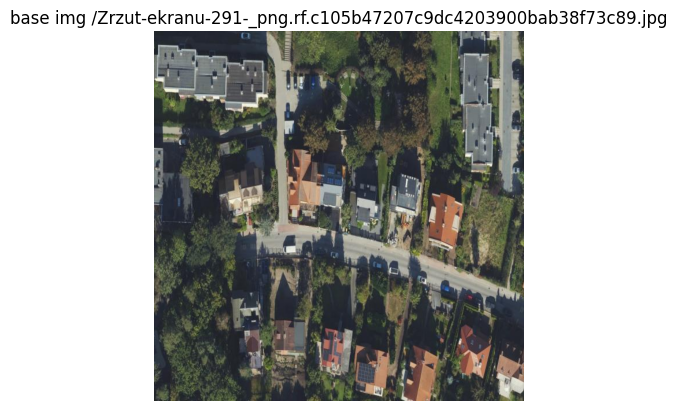


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-293-_png.rf.6501de77787921a2b0c0a3fac3ff7882.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1189.3ms
Speed: 5.6ms preprocess, 1189.3ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-294-_png.rf.ec19d20eeaa7c3a1ea9c829158bbebdc.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1104.1ms
Speed: 11.7ms preprocess, 1104.1ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-296-_png.rf.6cb900278610471a7c56cf2c1dda3c82.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1159.0ms
Speed: 8.1ms preprocess, 1159.0ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/model

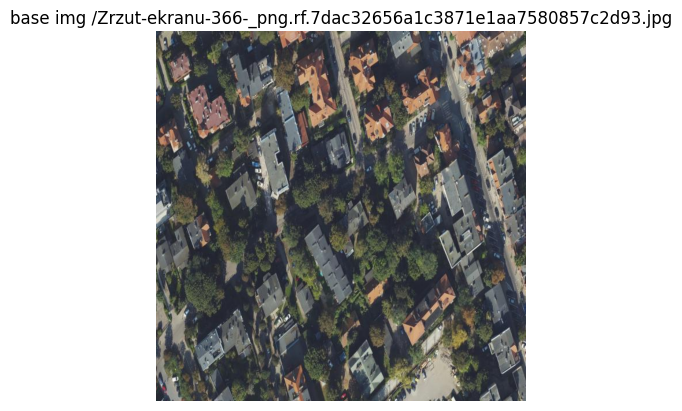


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-370-_png.rf.19faad52d9fa084df8ee42ecb144a1af.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1203.6ms
Speed: 6.1ms preprocess, 1203.6ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-371-_png.rf.a5aeb36b3d731bccbf03bb6872d3e06e.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1186.0ms
Speed: 6.0ms preprocess, 1186.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-373-_png.rf.9943593aabbafa50c488d826401c6879.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1173.2ms
Speed: 6.4ms preprocess, 1173.2ms inference, 7.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/mar

tensor(0.3198, device='cuda:0')

In [35]:
sum_pv_segments(pilot, "pilot_segment", disp_img=True, display_coef=33)

## synthetic

### train


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.71f8969cded34224572d3d3b4b7bbf07.jpg: 1024x1024 1 0, 1120.3ms
Speed: 10.0ms preprocess, 1120.3ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)


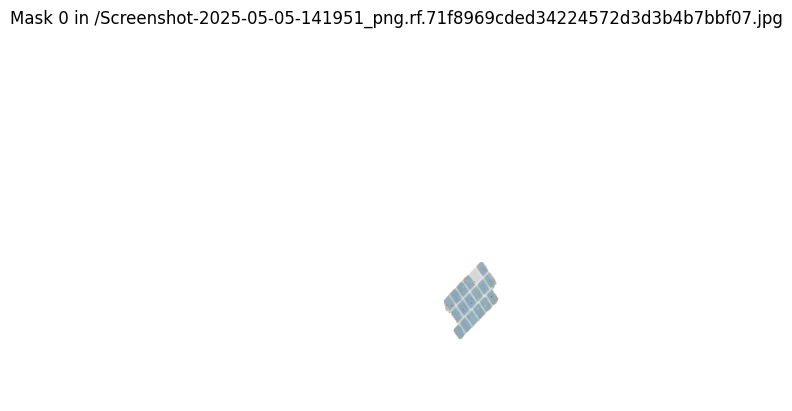

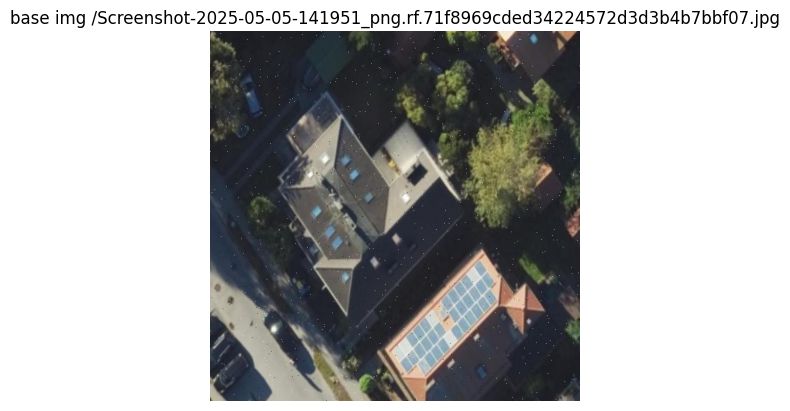


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.e8fc3301803b30373229d81dfd39a192.jpg: 1024x1024 1 0, 1 1, 1131.4ms
Speed: 5.8ms preprocess, 1131.4ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-141951_png.rf.fce413ee410f6a8aa17e7b99dccc1725.jpg: 1024x1024 1 0, 1127.2ms
Speed: 7.2ms preprocess, 1127.2ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/Screenshot-2025-05-05-142049_png.rf.3ba62fc2067b311bf450a681e11330af.jpg: 1024x1024 1 0, 1 1, 1138.4ms
Speed: 8.5ms preprocess, 1138.4ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/tr

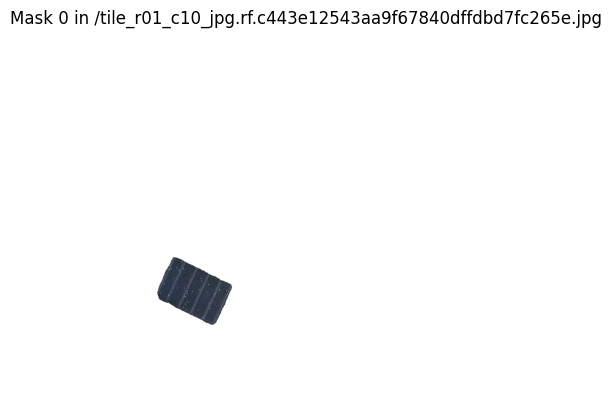

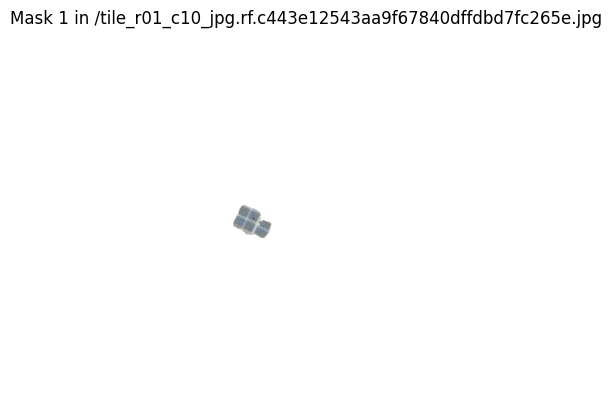

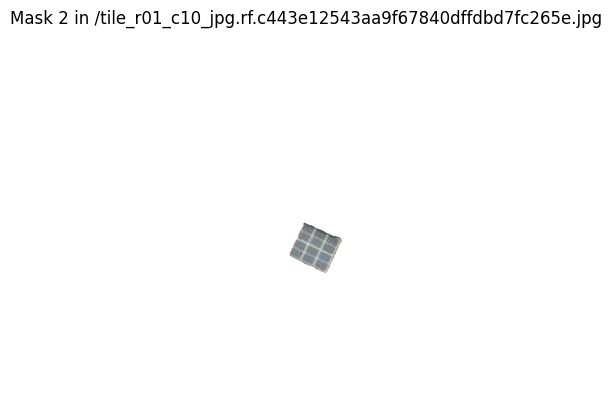

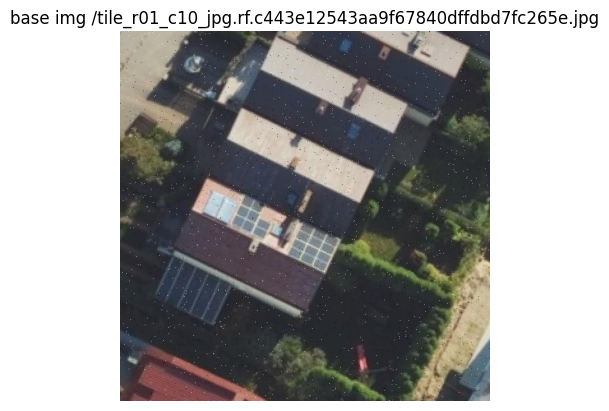


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r01_c10_jpg.rf.d0bc46921471d10337c38cf533e39d8c.jpg: 1024x1024 1 0, 1110.7ms
Speed: 11.8ms preprocess, 1110.7ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r02_c01_jpg.rf.28ff9efcb558b92c9bfa835c75c62c4b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1178.6ms
Speed: 5.8ms preprocess, 1178.6ms inference, 5.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/tile_r02_c01_jpg.rf.a162a1877cd5a9c7802054c5044b06a9.jpg: 1024x1024 1 0, 1 1, 1 2, 1174.2ms
Speed: 5.5ms preprocess, 1174.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/t

tensor(3.2677, device='cuda:0')

In [36]:
sum_pv_segments(synth_train, disp_img=True)

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142243_png.rf.0c1fc1b110982ed45002e385f2ed0cdf.jpg: 1024x1024 1 0, 1 1, 1184.7ms
Speed: 13.6ms preprocess, 1184.7ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)


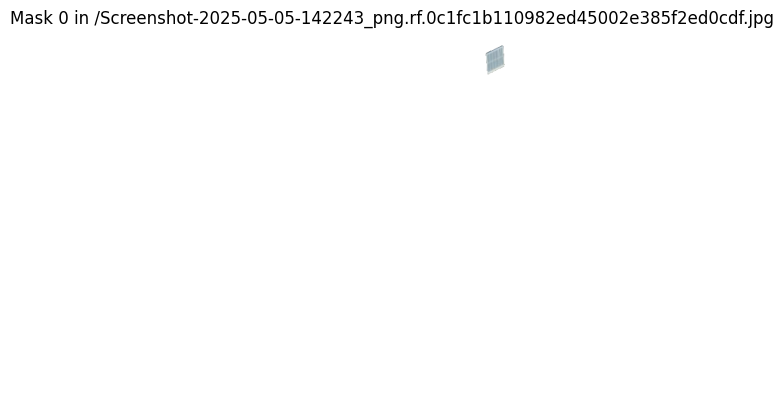

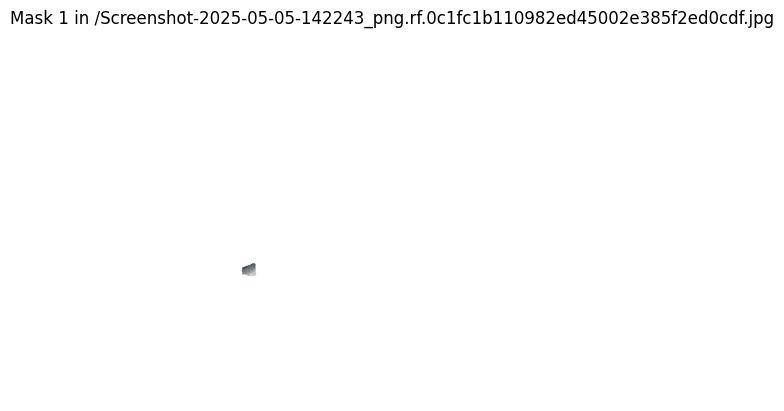

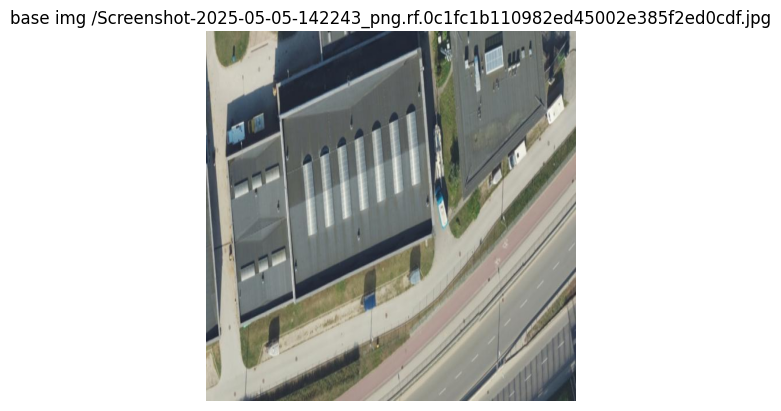


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142342_png.rf.d7373a2eee092999859ee3a20a9e7b13.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1243.3ms
Speed: 12.0ms preprocess, 1243.3ms inference, 14.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142412_png.rf.7346005e071261338a10472ee5ae78b1.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1443.7ms
Speed: 10.2ms preprocess, 1443.7ms inference, 3.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/Screenshot-2025-05-05-142633_png.rf.ab6b4d1c58ab4c00e3ddbed5118af28b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1151.5ms
Speed: 9.9ms preprocess, 1151.5ms inference, 2.2ms postproce

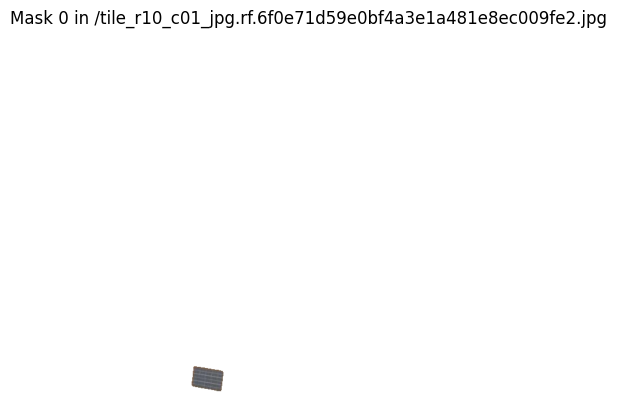

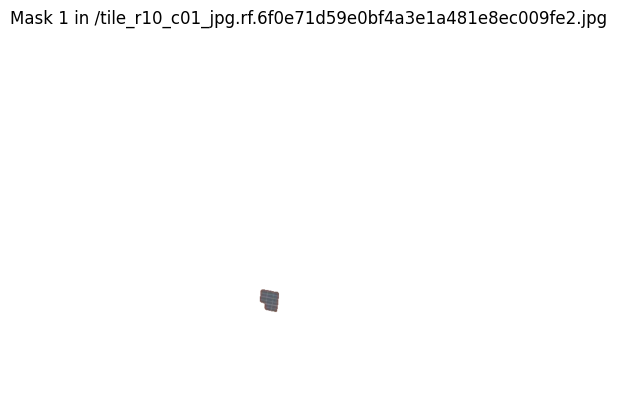

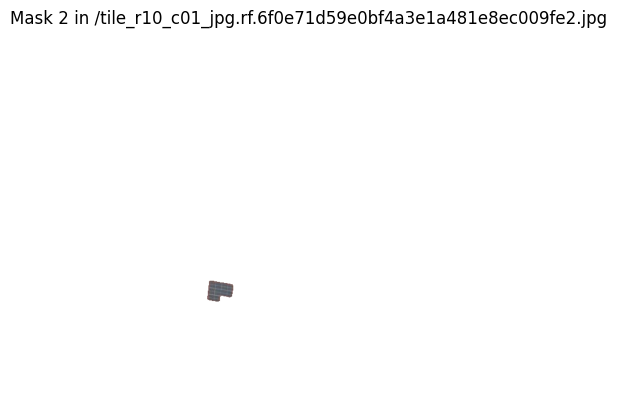

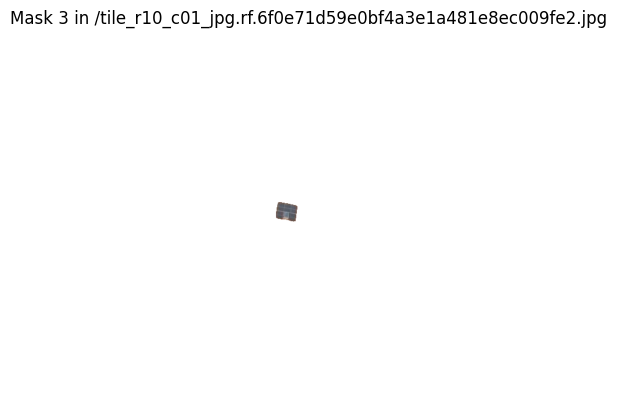

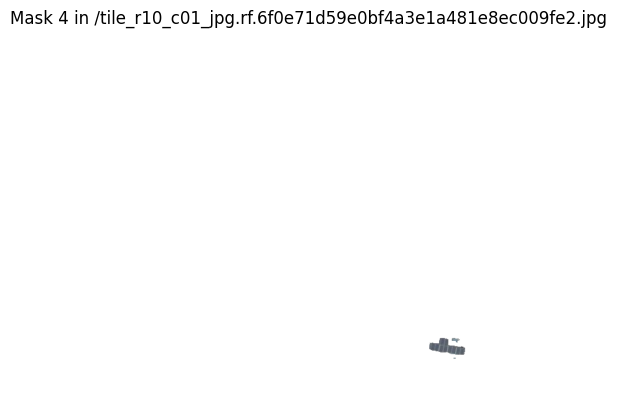

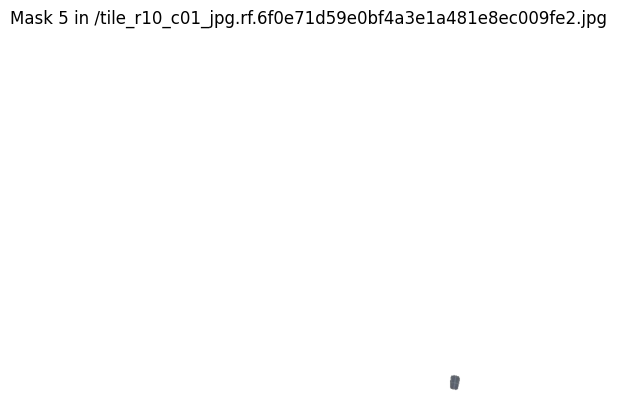

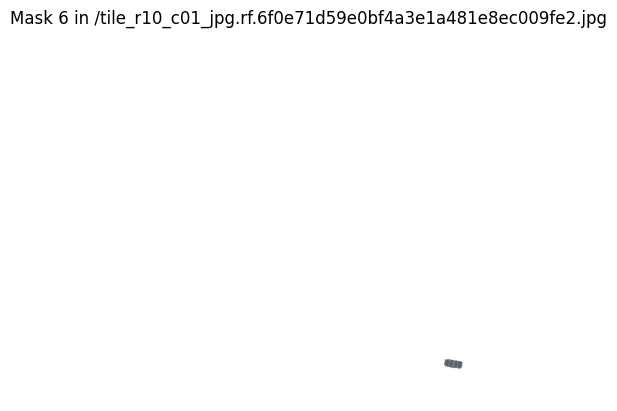

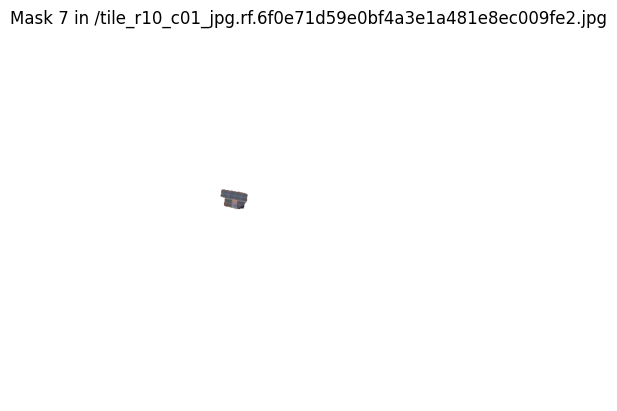

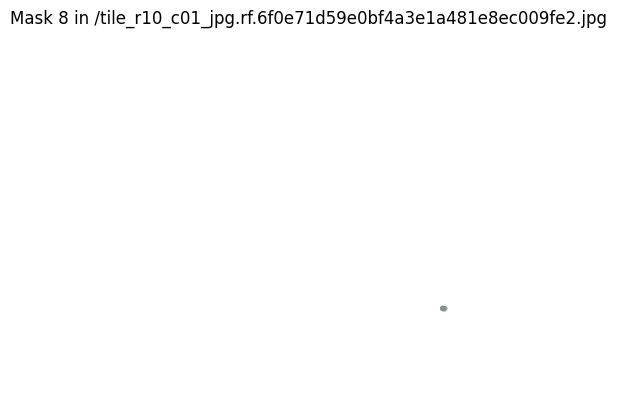

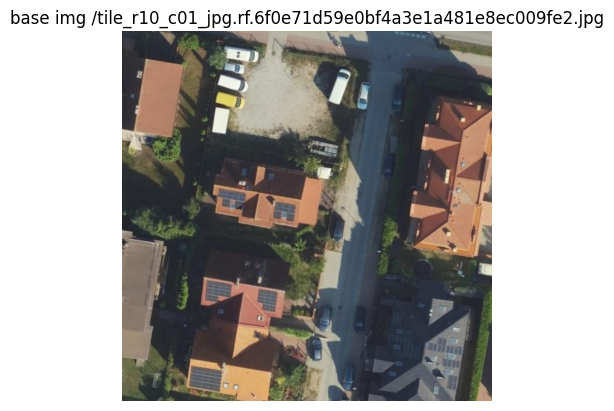


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/tile_r11_c11_jpg.rf.2911fea8c34ab33e7416cb2e7b168c9b.jpg: 1024x1024 1 0, 1 1, 1 2, 1127.2ms
Speed: 7.2ms preprocess, 1127.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


tensor(0.3497, device='cuda:0')

In [37]:
sum_pv_segments(synth_valid, disp_img=True, display_coef=10)

### test


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143003_png.rf.fdf19d2ceff2192c26f9132617f7138b.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1133.1ms
Speed: 6.9ms preprocess, 1133.1ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)


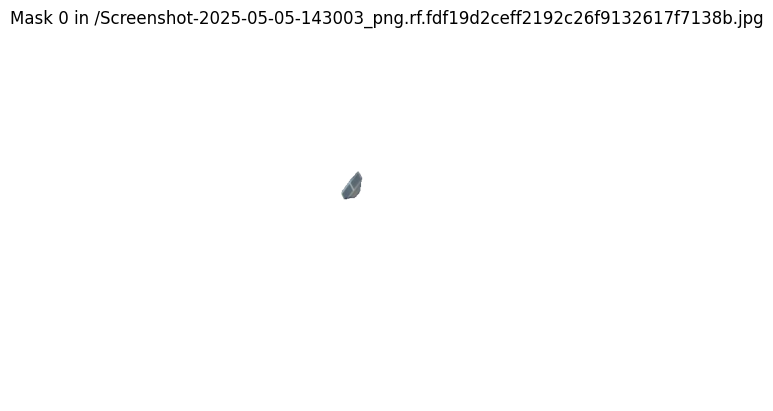

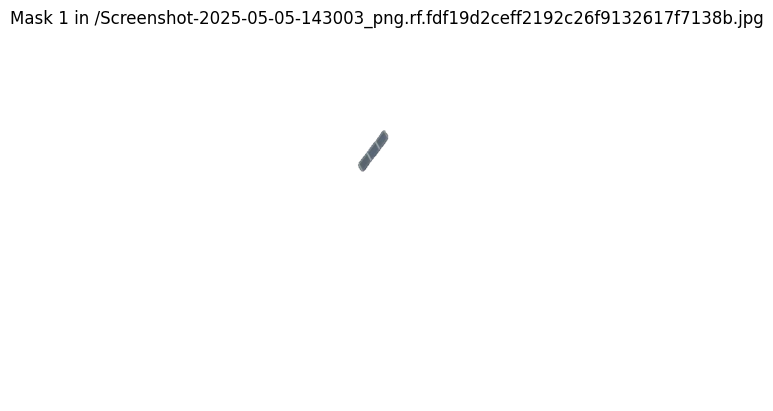

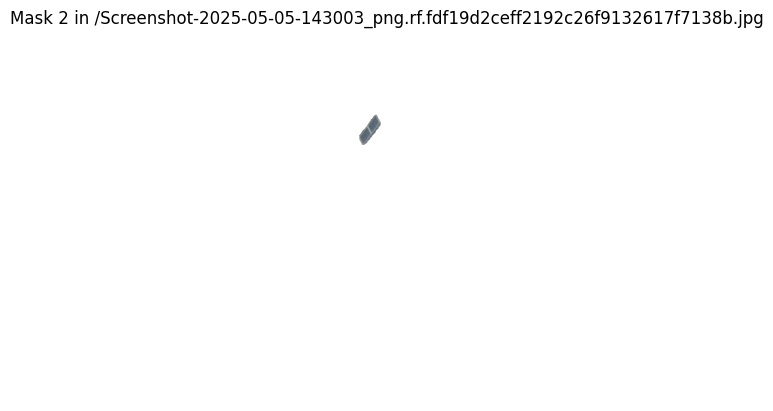

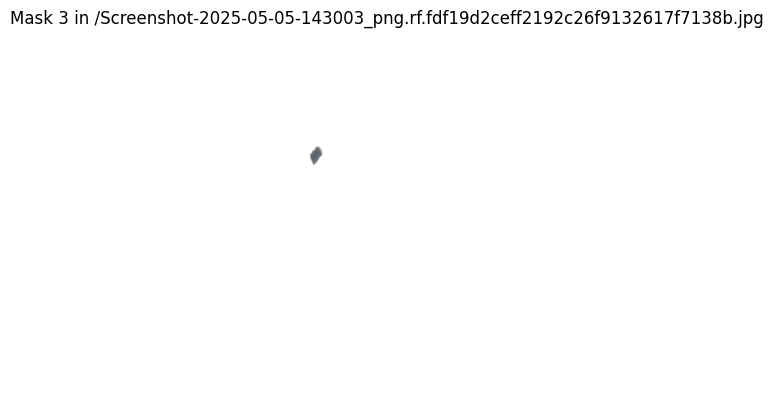

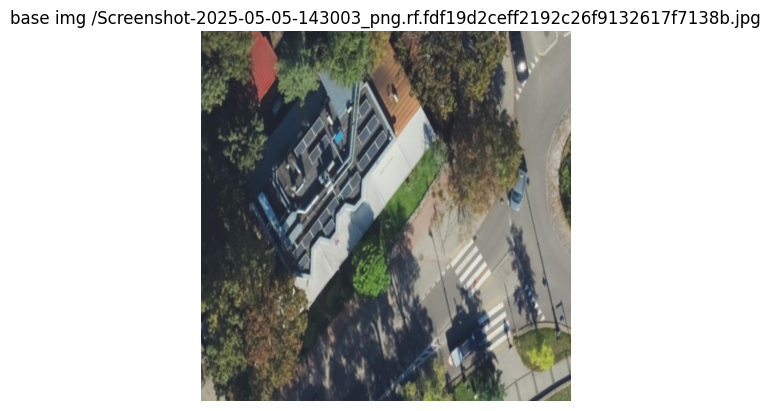


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143259_png.rf.5e77841caaec3af9f76d66e402dada53.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1127.9ms
Speed: 13.5ms preprocess, 1127.9ms inference, 131.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143340_png.rf.a3a5eb36c1ae28cb99b95aa17e3d2dd7.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1127.8ms
Speed: 6.2ms preprocess, 1127.8ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-143446_png.rf.315e9c958f42a449d1be8af194c0c849.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1170.3ms
Speed: 5.5ms preprocess, 1170.3ms inference, 2.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/m

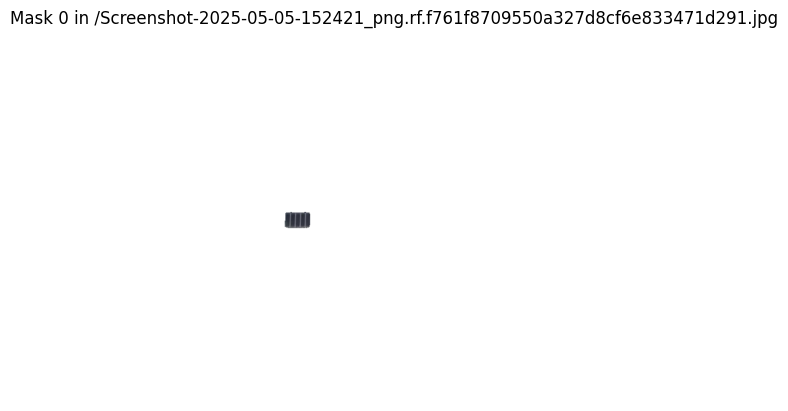

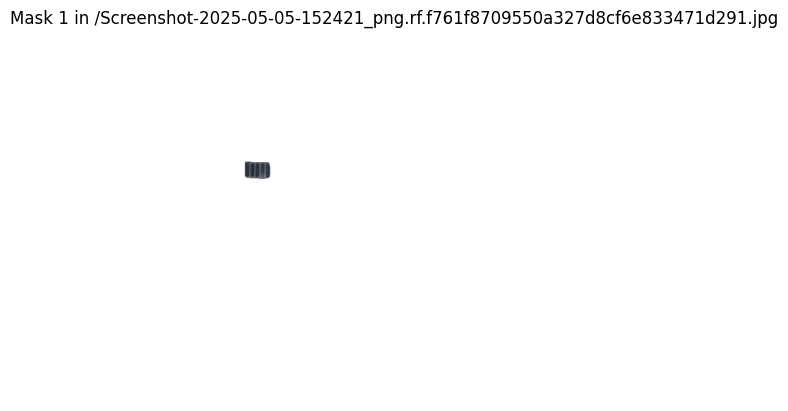

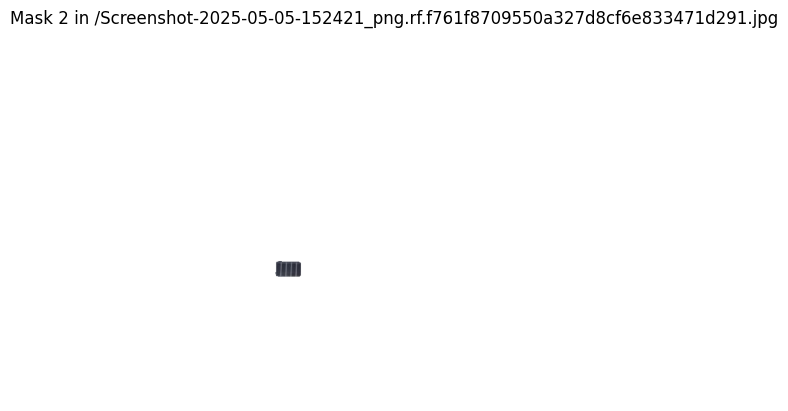

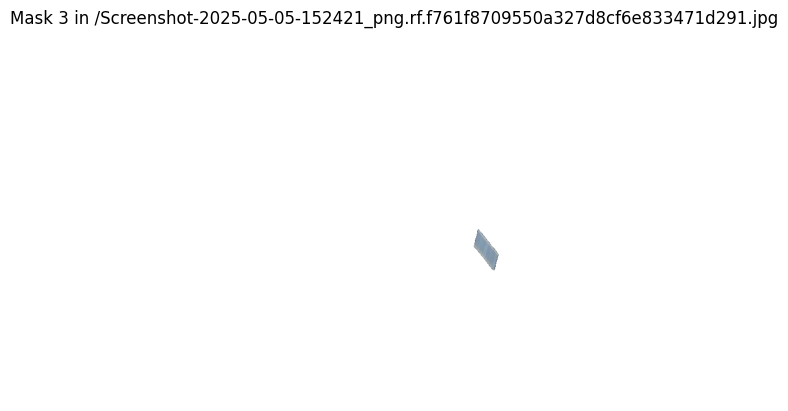

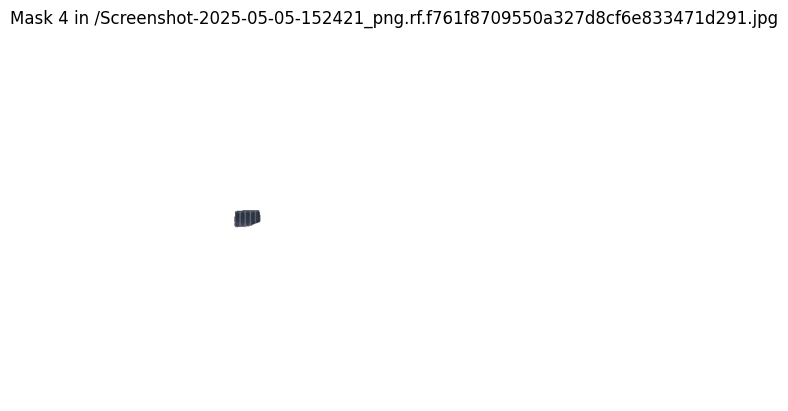

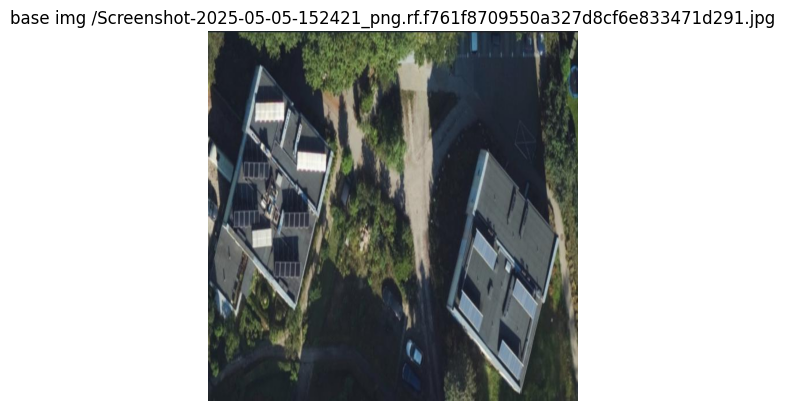


image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152659_png.rf.8f9866c533fda29648957ce56e047208.jpg: 1024x1024 1 0, 1 1, 1235.5ms
Speed: 5.9ms preprocess, 1235.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-152708_png.rf.f41dbefc9cab846445803af9b77bf4f1.jpg: 1024x1024 1 0, 1 1, 1 2, 1235.9ms
Speed: 7.8ms preprocess, 1235.9ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/Screenshot-2025-05-05-165307_png.rf.87be249f211bca30603740bc852ccd09.jpg: 1024x1024 1 0, 1 1, 1132.8ms
Speed: 5.5ms preprocess, 1132.8ms inference, 2.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/auto_pv_to_fine_tunning.v4i.yolov8

tensor(0.3867, device='cuda:0')

In [38]:
sum_pv_segments(synth_test, disp_img=True, display_coef=10)

## Rzeszów

### valid


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/006_jpg.rf.edb579f7fc522ebd95b41fb2224d97d9.jpg: 1024x1024 1 0, 1 1, 1129.1ms
Speed: 9.0ms preprocess, 1129.1ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 1024)


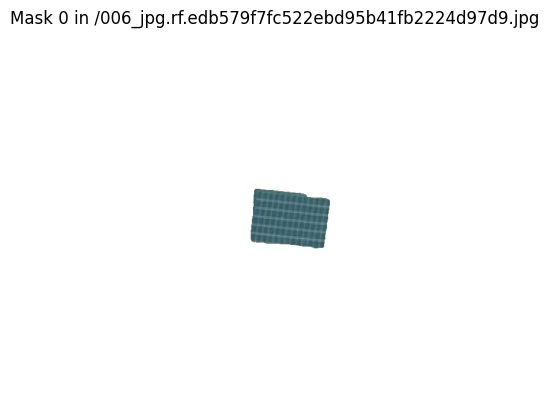

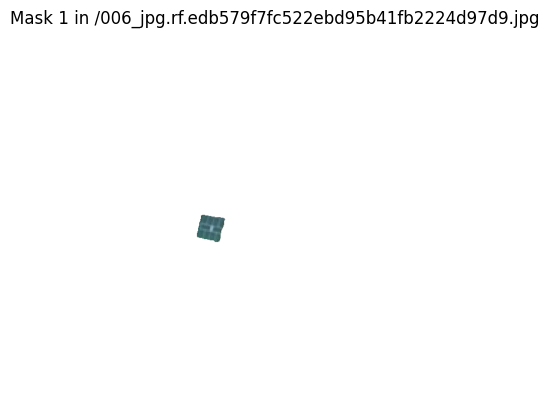

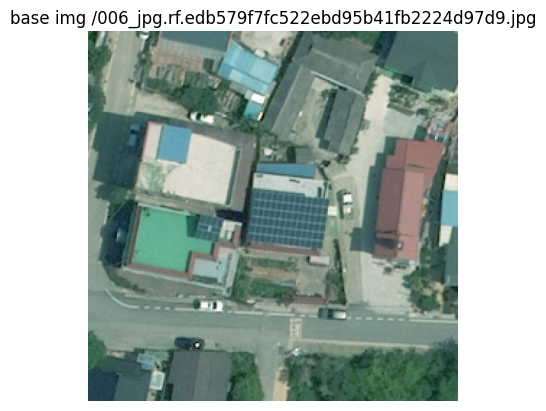


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/024_jpg.rf.2071584ae535b47199dc091fd2420eb7.jpg: 1024x1024 1 0, 1 1, 1117.3ms
Speed: 5.7ms preprocess, 1117.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/036_jpg.rf.6be19359a40387d36e881c8e4589c4ef.jpg: 1024x1024 1 0, 1 1, 1 2, 1134.1ms
Speed: 6.7ms preprocess, 1134.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/037_jpg.rf.da5d0dcc434c04835bb7701b18a7405d.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1137.5ms
Speed: 7.3ms preprocess, 1137.5ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/039_jpg.rf.1ea41523c4113f9b7b085ba96ebca1c9.

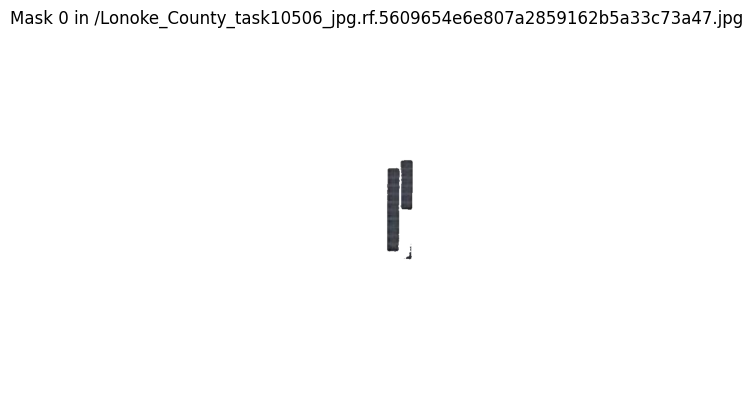

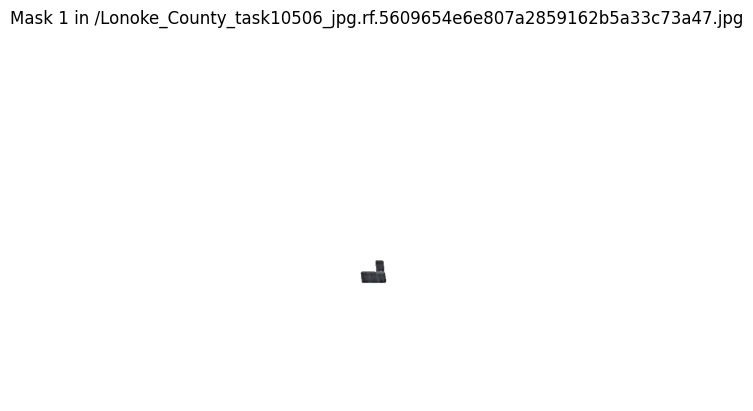

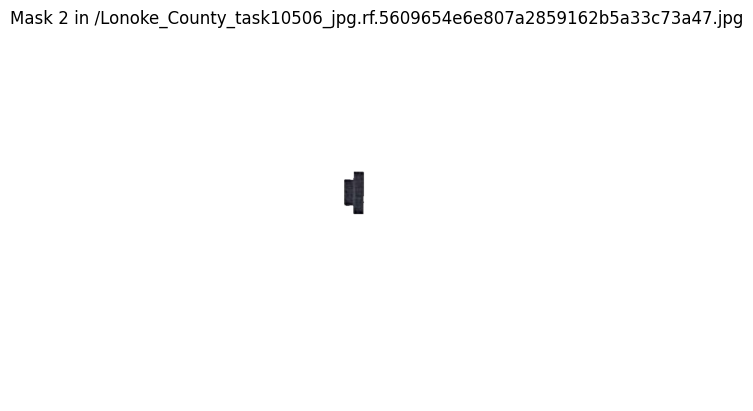

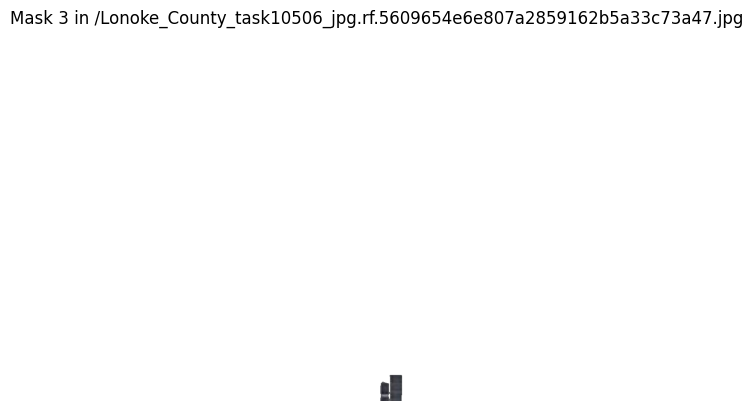

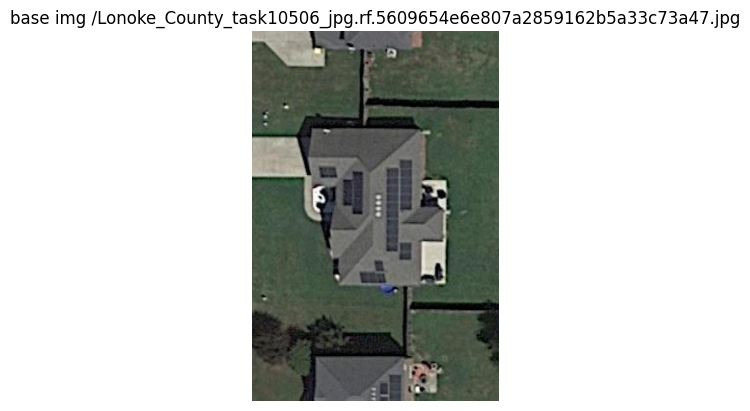


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task10811_jpg.rf.ad15471c497bcfd012133246f80853e5.jpg: 1024x1024 1 0, 1 1, 1152.2ms
Speed: 8.6ms preprocess, 1152.2ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task11768_jpg.rf.11f1ea8fb8e18e03efa140ad20668caa.jpg: 1024x1024 1 0, 1141.0ms
Speed: 6.5ms preprocess, 1141.0ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_County_task1258_jpg.rf.b137128531187339a879b284ebae9e4f.jpg: 1024x1024 1 0, 1138.2ms
Speed: 6.2ms preprocess, 1138.2ms inference, 3.6ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Lonoke_Cou

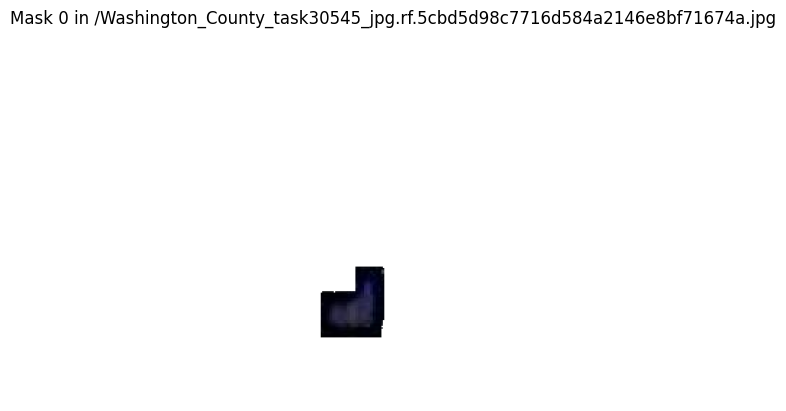

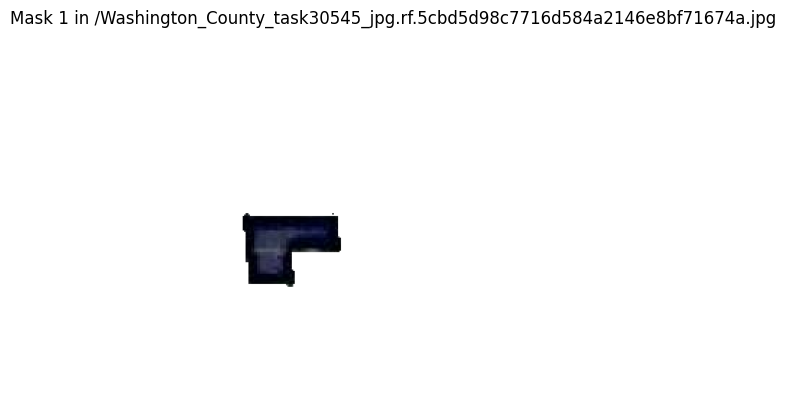

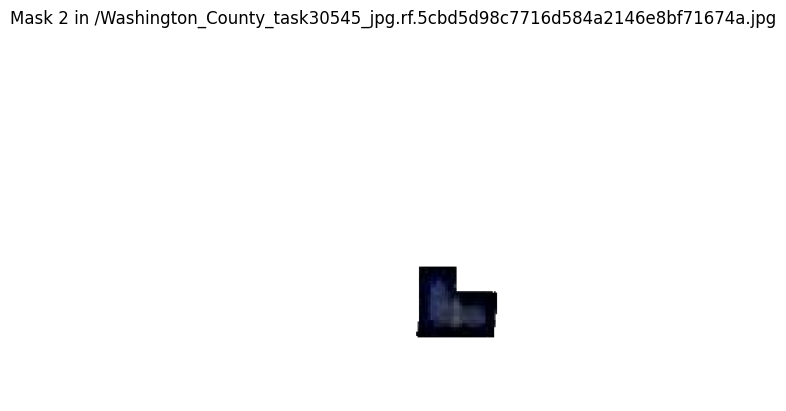

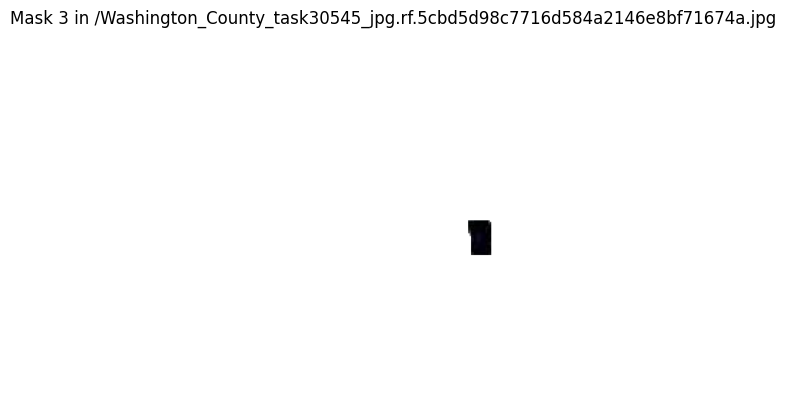

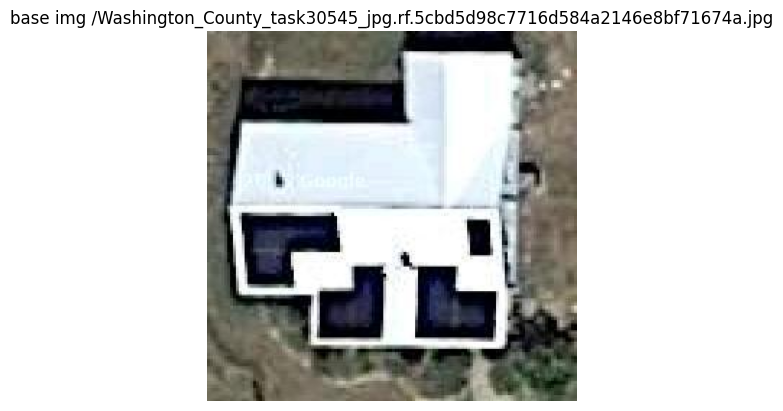


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Washington_County_task31314_jpg.rf.ce1a9efd5ed3716ea493dfa0f421b2df.jpg: 1024x1024 1 0, 1127.1ms
Speed: 7.6ms preprocess, 1127.1ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Washington_County_task34401_jpg.rf.67041f1f314705588c62ee2ef6bdfacc.jpg: 1024x1024 1 0, 1130.0ms
Speed: 7.5ms preprocess, 1130.0ms inference, 7.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/Washington_County_task37607_jpg.rf.f2f7e1cd134c606f02ada9933577d39f.jpg: 1024x1024 1 0, 1 1, 1129.9ms
Speed: 6.7ms preprocess, 1129.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/valid/imag

tensor(25.1927, device='cuda:0')

In [39]:
sum_pv_segments(rzeszow_valid, disp_img=True, display_coef=333)

### test


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/002_jpg.rf.ebb4fe3f88e1352ef612c9da79184d51.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1152.4ms
Speed: 10.1ms preprocess, 1152.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


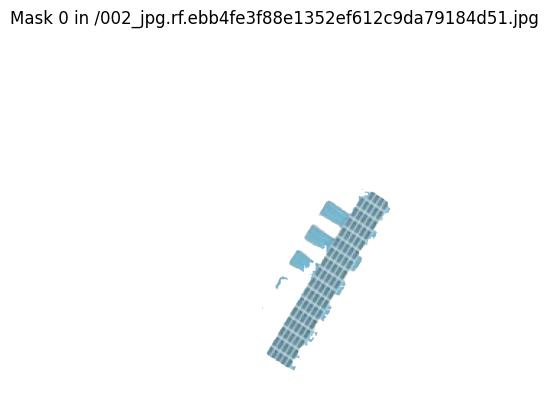

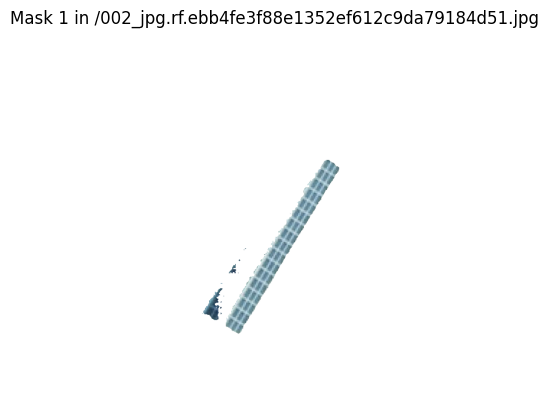

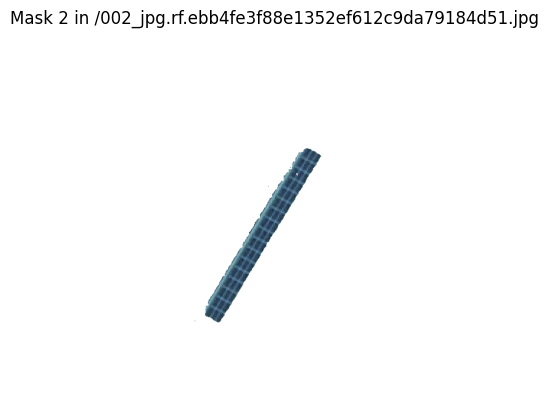

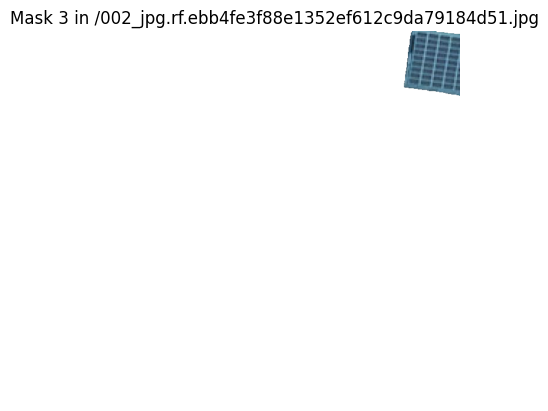

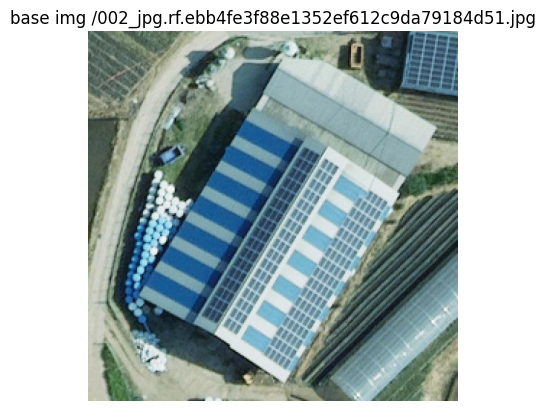


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/006_jpg.rf.96d8625007780d1583d28aafe467a98b.jpg: 1024x1024 1 0, 1 1, 1134.8ms
Speed: 5.9ms preprocess, 1134.8ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/010_jpg.rf.0f7f56bba5e16ee4258b6f6c8b502c89.jpg: 1024x1024 1 0, 1122.8ms
Speed: 7.3ms preprocess, 1122.8ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/011_jpg.rf.98f9be51134c86f010b4bd1810e64d41.jpg: 1024x1024 1 0, 1138.5ms
Speed: 5.6ms preprocess, 1138.5ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1 1, 1 2,

KeyboardInterrupt: 

In [40]:
sum_pv_segments(rzeszow_test, disp_img=True, display_coef=333)